# Getting parameters from runs with py3DCORE_h4c

In [27]:
%load_ext autoreload

%autoreload 2

import heliosat as heliosat
import logging as logging
import datetime as datetime
import numpy as np
import os as os
import pickle as pickle
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt
import pandas as pds
import seaborn as sns

from py3dcore_h4c.fitter.base import custom_observer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from heliosat.util import sanitize_dt

logging.basicConfig(level=logging.INFO)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

For plotting, we need the following information about the times.

In [29]:
t_launch = datetime.datetime(2022, 9, 5, 18, 45, tzinfo=datetime.timezone.utc) # launch time assumed at CME impact at PSP at 14.72 Rs

t_s = datetime.datetime(2022, 9, 7, 8, tzinfo=datetime.timezone.utc) 
t_e = datetime.datetime(2022, 9, 8, 5, tzinfo=datetime.timezone.utc)

t_fit = [
        datetime.datetime(2022, 9, 7, 9, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 15, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 20, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 8, 2, tzinfo=datetime.timezone.utc)
]

In [30]:
# specify directory from which to read pickle file (= results of runs)
path = 'solo06092022_heeq_512_restrP_2/'

# Get the list of all files in path
dir_list = sorted(os.listdir(path))

resfile = []
respath = []
# we only want the pickle-files
for file in dir_list:
    if file.endswith(".pickle"):
        resfile.append(file) 
        respath.append(os.path.join(path,file))
        print(os.path.join(path, file))       

solo06092022_heeq_512_restrP_2/00.pickle
solo06092022_heeq_512_restrP_2/01.pickle
solo06092022_heeq_512_restrP_2/02.pickle
solo06092022_heeq_512_restrP_2/03.pickle
solo06092022_heeq_512_restrP_2/04.pickle
solo06092022_heeq_512_restrP_2/05.pickle
solo06092022_heeq_512_restrP_2/06.pickle
solo06092022_heeq_512_restrP_2/07.pickle
solo06092022_heeq_512_restrP_2/08.pickle
solo06092022_heeq_512_restrP_2/09.pickle


INFO:py3dcore_h4c.fitter.base:Using HelioSat to retrieve observer data


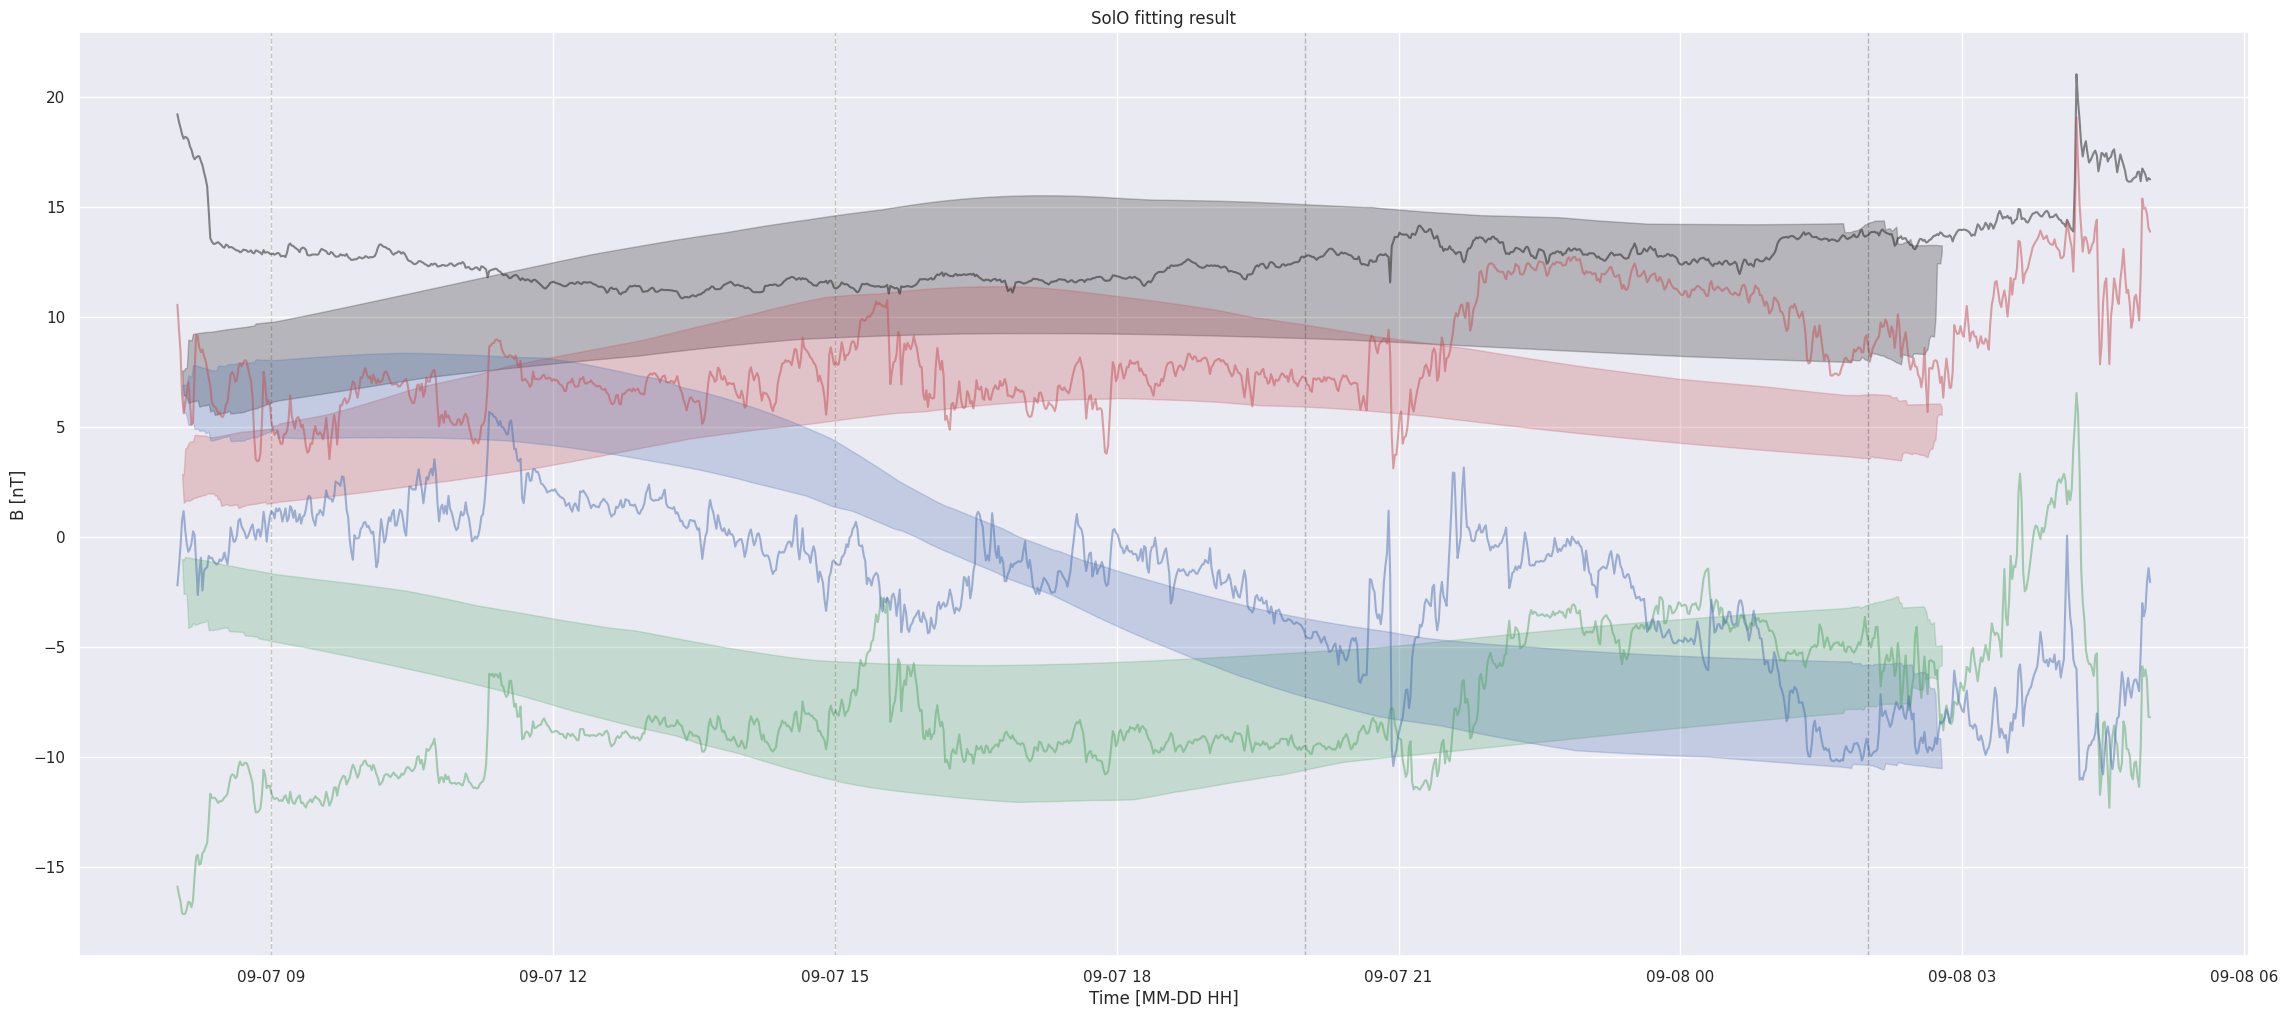

In [31]:
# plot the results 

#t_s_psp = datetime.datetime(2022, 6, 2, 10, tzinfo=datetime.timezone.utc)
#t_e_psp = datetime.datetime(2022, 6, 3, 2, tzinfo=datetime.timezone.utc)

obs_obj = custom_observer('solo_2022sep.p')

# get measurements from PSP via heliosat
tt, bb = obs_obj.get([t_s, t_e], "mag", reference_frame="HEEQ", as_endpoints=True, return_datetimes=True, smoothing="gaussian")

# get ensemble_data
ed = py3dcore_h4c.generate_ensemble(respath[-1], tt, reference_frame="HEEQ", reference_frame_to="HEEQ", max_index=128)

plt.figure(figsize=(28, 12))
plt.title("SolO fitting result")
plt.plot(tt, np.sqrt(np.sum(bb**2, axis=1)), "k", alpha=0.5)
plt.plot(tt, bb[:, 0], "r", alpha=0.5)
plt.plot(tt, bb[:, 1], "g", alpha=0.5)
plt.plot(tt, bb[:, 2], "b", alpha=0.5)
plt.fill_between(tt, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(tt, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(tt, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(tt, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_fit:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.savefig(path+'%s.png' %resfile[-1])    
plt.show()

In [32]:
# read from pickle file
file = open(respath[-1], "rb")
data = pickle.load(file)
file.close()

# get overview of whats in pickle file
cnt = 0
for item in data:
    print(item)
    cnt += 1
    
# get index ip for run with minimum eps    
epses_t = data["epses"]
ip = np.argmin(epses_t[0:511]) #      

# get parameters (stored in iparams_arr) for the run with minimum eps
model_objt = data["model_obj"]
iparams_arrt = model_objt.iparams_arr

resparams = iparams_arrt[ip]
print('lon:', resparams[1], '\n', 'lat:', resparams[2], '\n', 'inc:', resparams[3], '\n', 'diameter 1 AU:', resparams[4], '\n', 'aspect ratio:', resparams[5],
     '\n', 'launch radius:', resparams[6], '\n', 'launch speed:', resparams[7], '\n', 'T factor:', resparams[8], '\n',
      'expansion rate (fixed):', resparams[9], '\n', 'magnetic field decay rate (fixed):', resparams[10], '\n',
     'magnetic field 1 AU:', resparams[11], '\n', 'drag coefficient:', resparams[12], '\n', 'sw background speed:', resparams[13])

locked
dt_0
model_kwargs
observers
model
iter_i
hist_eps
hist_time
hist_eps_dim
model_obj
data_obj
epses


IndexError: index 515 is out of bounds for axis 0 with size 512

## Use scatter plot to plot range of all runs

In [15]:
df = pds.DataFrame(iparams_arrt)
cols = df.columns.values.tolist()

# drop first column, and others in which you are not interested
df.drop(df.columns[[0, 9, 10]], axis=1, inplace=True)

# rename columns
df.columns = ['lon', 'lat', 'inc', 'D1AU', 'delta', 'launch radius', 'init speed', 't factor', 'B1AU', 'gamma', 'vsw']
print(df.head())

          lon        lat       inc      D1AU     delta  launch radius  \
0  169.177643 -10.078795  4.344784  0.338903  1.006287      15.274299   
1  177.971024 -12.037161  0.417422  0.309236  1.226446      15.032765   
2  173.065384 -10.941326  3.220892  0.342374  1.170271      15.795477   
3 -179.096909 -12.965922  1.567046  0.339666  1.189821      14.311629   
4  170.813599  -9.014597  4.905637  0.313004  1.140291      14.562726   

    init speed    t factor       B1AU     gamma         vsw  
0  1133.512329  178.822128  40.834034  0.655830  549.672302  
1  1968.173096  133.268692  26.822611  0.636041  500.186493  
2  1352.994263  169.150513  37.265362  1.953954  657.550659  
3  1880.270386  126.177116  25.790407  0.587759  539.210083  
4  1982.559326  201.955246  42.413296  1.178355  557.385010  


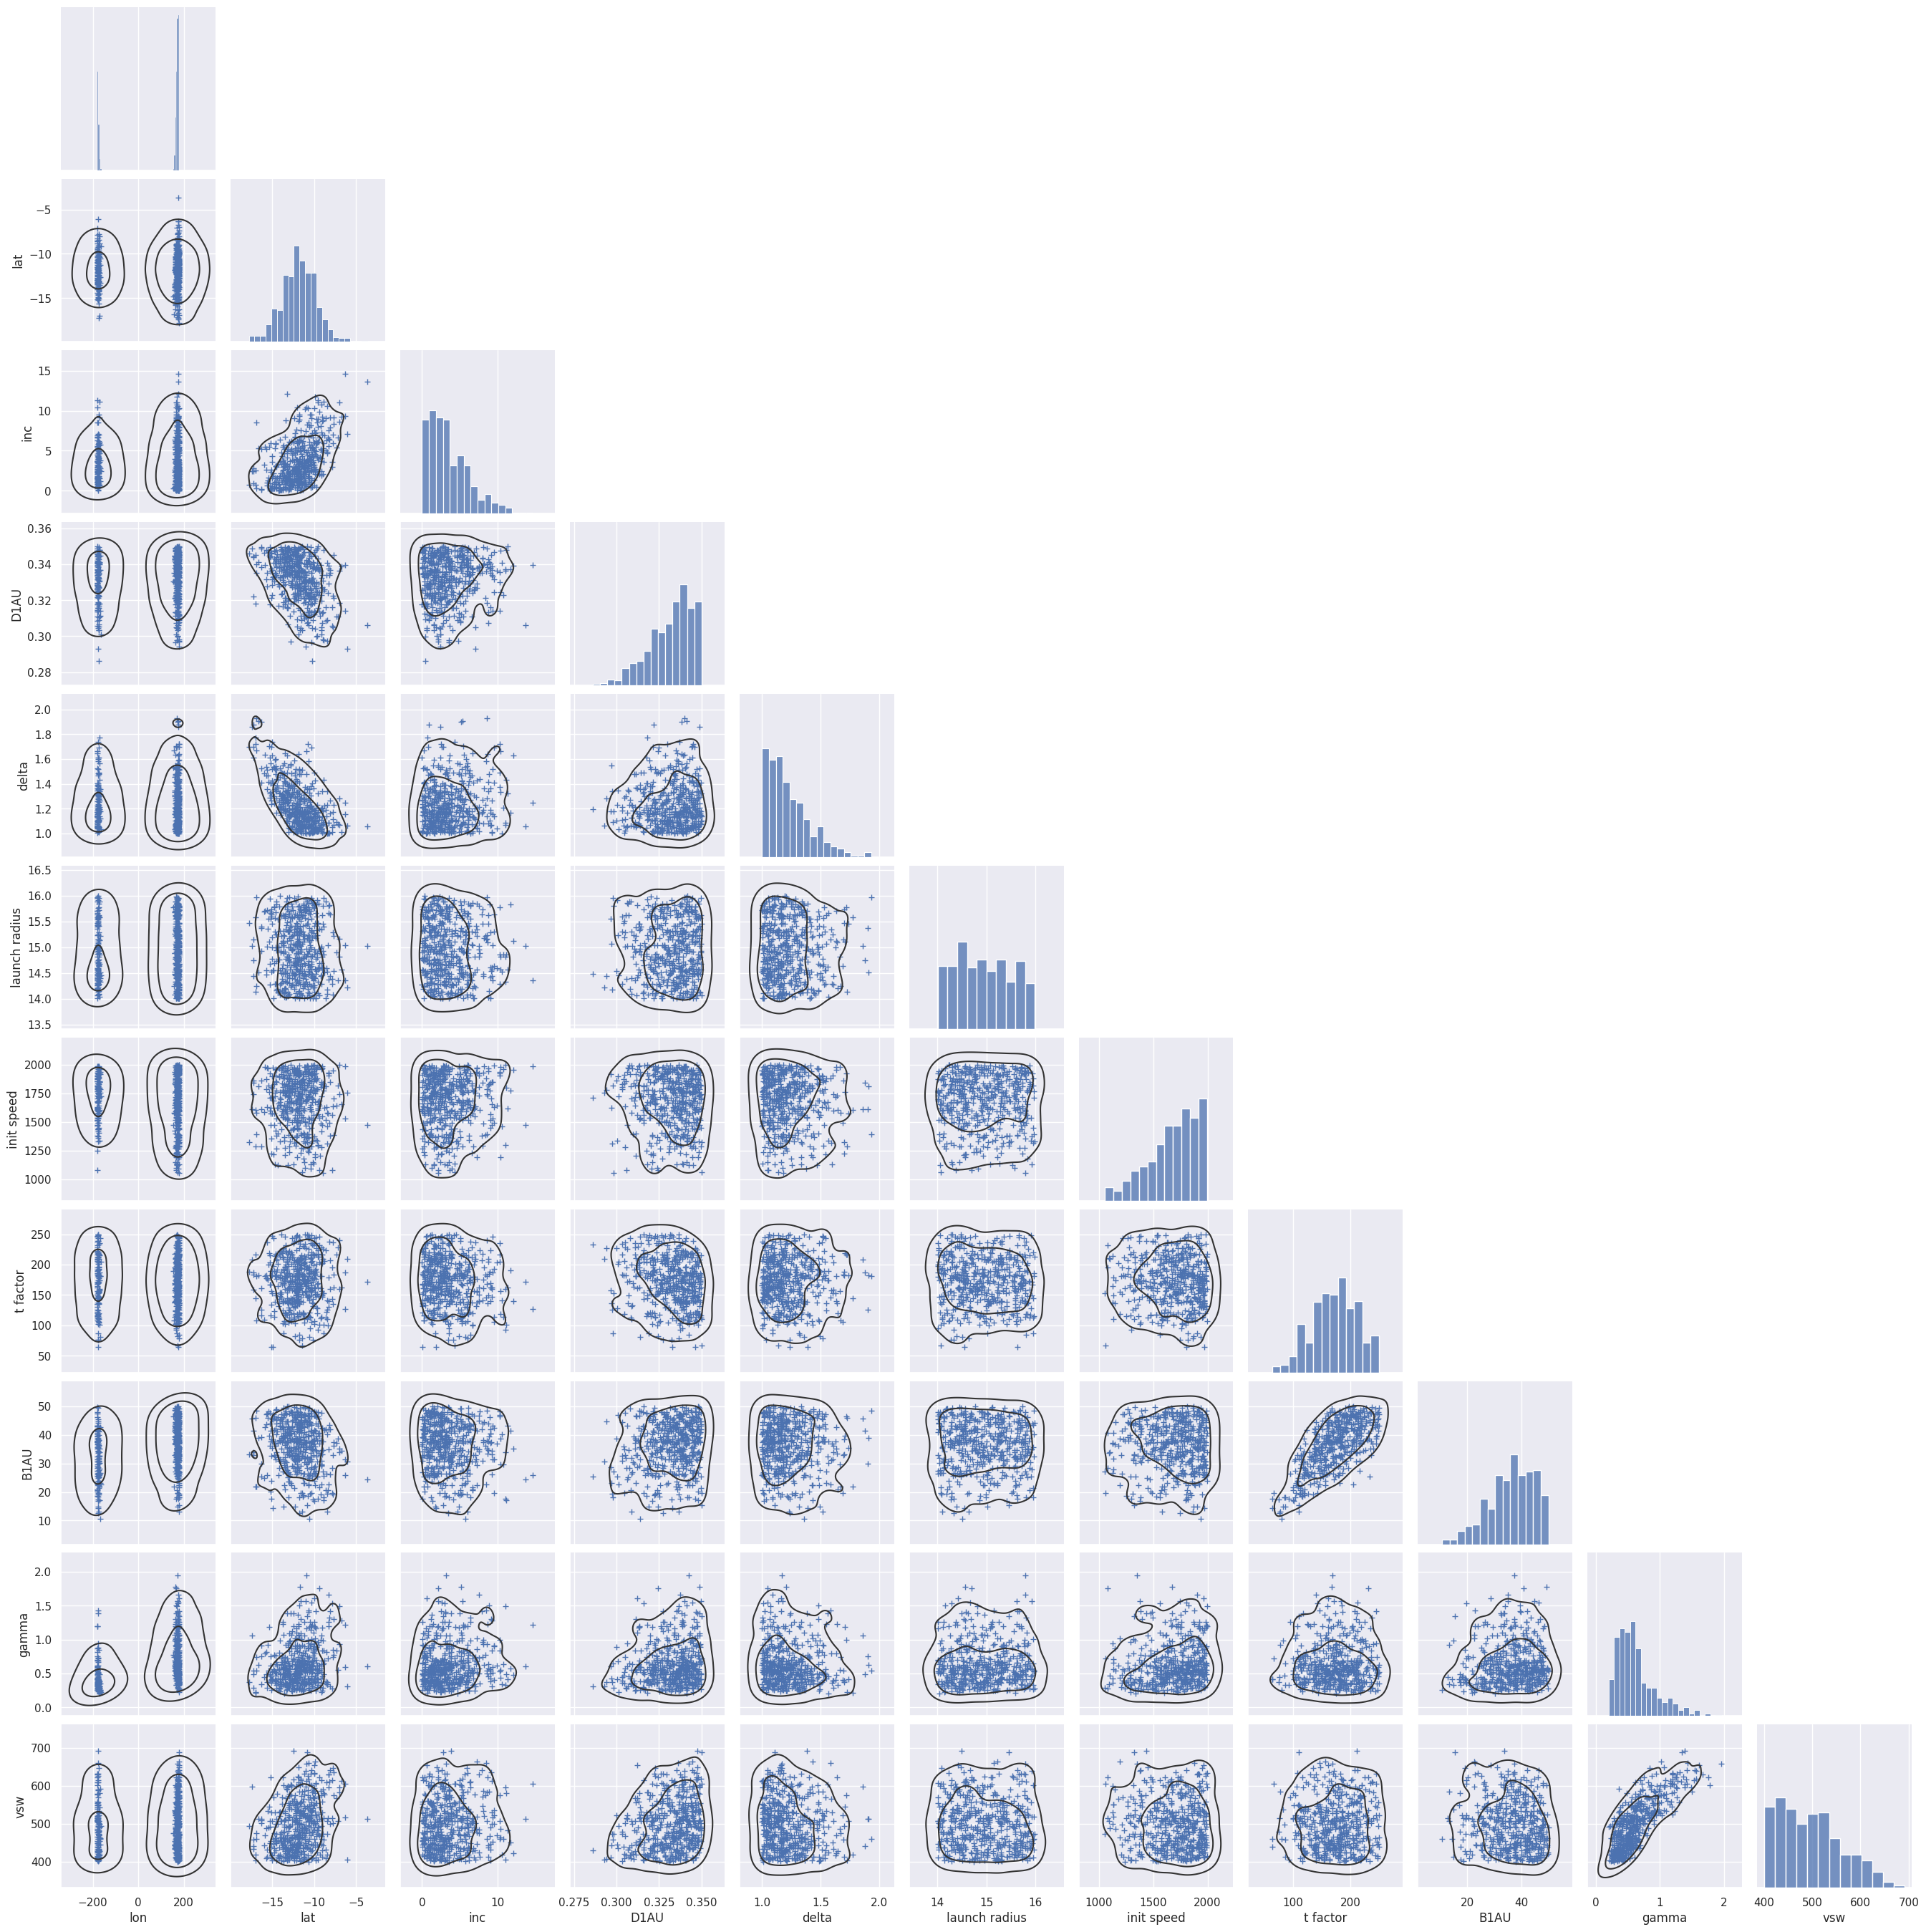

In [16]:
sns.set_style('white')
sns.set()

g = sns.pairplot(df, 
                 corner=True,
                 plot_kws=dict(marker="+", linewidth=1)
                )
g.map_lower(sns.kdeplot, levels=[0.05, 0.32], color=".2") #  levels are 2-sigma and 1-sigma contours
g.savefig(path+'scatter_plot_matrix.png')
plt.show()